In [1]:
import cv2
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [11]:
import cv2
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro', 'nastro', 'pappagallo', 'penna', 'spillatrice']
tp_tot, tn_tot, fp_tot, fn_tot = [], [], [], []


for tool in tqdm(tools):

    with open(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):

        # Ground truth.
        x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])

        image = cv2.imread(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_{pos+1}.png")

        if pos < 5:
            background_path = "C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\\background\\bianco.jpg"
        elif pos < 10:
            background_path = "C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\\background\\cemento.jpg"
        elif pos < 15:
            background_path = "C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\\background\\bancone.jpg"
        else:
            background_path = "C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\\background\\coperta.jpg"



        # IMAGE PREPROCESSING
        a = 3
        blur = cv2.GaussianBlur(image, (a, a), cv2.BORDER_DEFAULT)
        gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)


        # BACKGROUND SUBTRACTION
        background = cv2.imread(background_path)
        blur_bg = cv2.GaussianBlur(background, (a, a), cv2.BORDER_DEFAULT)
        background = cv2.cvtColor(blur_bg, cv2.COLOR_BGR2GRAY)
        diff = background - gray - background 

        # HANDLE BACKGROUND'S PATTERNS
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        eroded_gray = cv2.erode(diff, kernel, iterations=3)







        # cv2.imshow("Masked Image", mask)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # # # applicare la soglia alla mappa di sfondo
        _, mask = cv2.threshold(eroded_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


        # # Applicare ground truth all'immagine.
        truth_mask = np.zeros_like(mask)
        cv2.fillPoly(truth_mask, [vertices], 255)
        truth_mask = truth_mask.astype(bool).flatten()

        opening = mask.astype(bool)
        # opening = np.array([not elem for elem in opening.flatten()])

        # Confronto tra segmentazione e ground truth.
        ground_truth = truth_mask.flatten()
        if opening.flatten()[0] == True:
            predictions = [not elem for elem in opening.flatten()]
        else:
            predictions = [elem for elem in opening.flatten()]

        tn, fp, fn, tp = confusion_matrix(ground_truth, predictions, labels=[True, False]).ravel()
        tp_tot.append(tp)
        tn_tot.append(tn)
        fp_tot.append(fp)
        fn_tot.append(fn)

100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


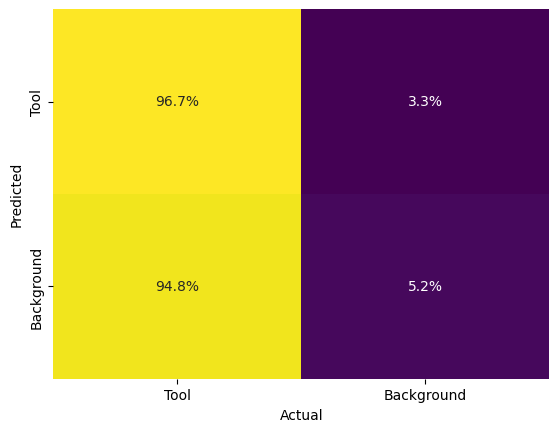

In [12]:
sum_tp, sum_tn, sum_fp, sum_fn = sum(tp_tot), sum(tn_tot), sum(fp_tot), sum(fn_tot) 

cf_matrix = np.array([[sum_tp/(sum_tp+sum_fp), sum_fp/(sum_tp+sum_fp)],
                       [sum_fn/(sum_tn+sum_fn), sum_tn/(sum_tn+sum_fn)]])

labels = ['Tool', 'Background']
sns.heatmap(cf_matrix, annot=True, cmap='viridis',  xticklabels=labels, yticklabels=labels, cbar=False, fmt=".1%")
plt.title("")
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [ ]:
# pacchetti utilizzati.
import os
import cv2
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

cwd = os.getcwd()



# test-set
path = os.path.join(cwd, f"images/Test_set/")
image_files = glob.glob(path + '*.png')

for pos in range(len(image_files)):
    path = f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\Test_set\\test_{pos+1}.png"
    image = cv2.imread(path)

    if pos < 10:
        background_path = "C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\\background\\bianco.jpg"
    elif pos < 20:
        background_path = "C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\\background\\cemento.jpg"
    else:
        background_path = "C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\\background\\bancone.jpg"





    # IMAGE PREPROCESSING
        
    a = 3
    blur = cv2.GaussianBlur(image, (a, a), cv2.BORDER_DEFAULT)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)


    # BACKGROUND SUBTRACTION
    background = cv2.imread(background_path)
    blur_bg = cv2.GaussianBlur(background, (a, a), cv2.BORDER_DEFAULT)
    background = cv2.cvtColor(blur_bg, cv2.COLOR_BGR2GRAY)
    diff = background - gray - background 

    # HANDLE BACKGROUND'S PATTERNS
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    eroded_gray = cv2.erode(diff, kernel, iterations=3)


    cv2.imshow("Masked Image", eroded_gray)
    cv2.waitKey(0)
    cv2.destroyAllWindows()